Задача которую я буду решать -  классификация еды по картинке

In [18]:
# !pip install --upgrade torch torchvision torchtext torchaudio transformers sentencepiece
import torch
import pandas as pd
import numpy as np
# from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
# !pip install datasets
# from datasets import load_dataset
# from sklearn.datasets import load_files
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
# from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from torch.utils.data import random_split,DataLoader
from tqdm.notebook import tqdm
# from .autonotebook import tqdm

In [19]:
!pwd
picture_height = 256
transformation = transforms.Compose([
    ToTensor(),transforms.Resize((picture_height, picture_height),antialias=False),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transforms.CenterCrop(224)
])

/kaggle/working


In [20]:
dataset = ImageFolder("/kaggle/input/food41/images",transform = transformation)
print(dataset)
train_data, valid_data, test_data = random_split(dataset, (70000, 5000, 26000))

Dataset ImageFolder
    Number of datapoints: 101000
    Root location: /kaggle/input/food41/images
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=False)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               CenterCrop(size=(224, 224))
           )


In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)


In [23]:
print(train_loader)
dataiter = iter(train_loader)

In [24]:
imgs, labels = next(dataiter)

In [25]:
def show(imgs, labels):
  f, axes = plt.subplots(1, 8, figsize=(30, 30))
  for i, axis in enumerate(axes):
    axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
    axes[i].set_title(labels[i].numpy())
  plt.show()

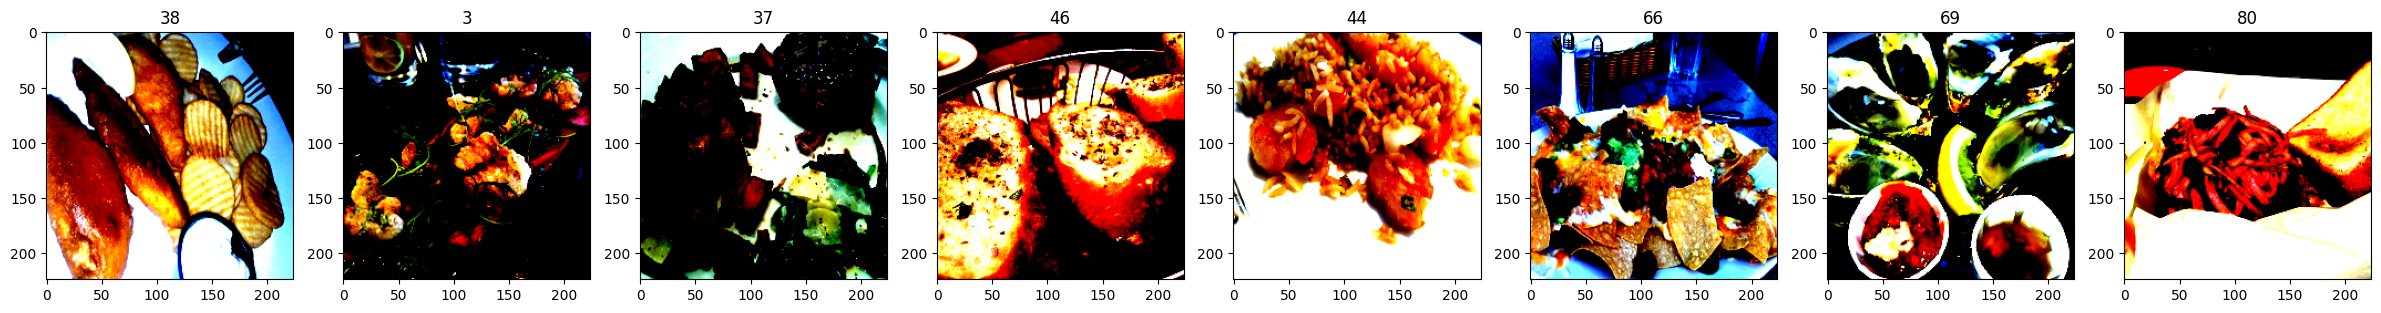

In [26]:
show(imgs, labels)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

Для обучения выбрал архитектуру efficient net предобученную на датасете imagenet с двумя дополнительными линейными слоями.

In [29]:
from torchvision import models
efficientnet_v2_s = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
efficientnet_v2_s.to(device)
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.efficientnet_v2_s = efficientnet_v2_s
    self.fc1 = nn.Linear(1000,4096)
    self.fc3 = nn.Linear(4096, 101)
    self.dropout = nn.Dropout(0.1)
  def forward(self, x):
    x = self.efficientnet_v2_s(x)
    x = F.tanh(self.fc1(x))
    x = self.dropout(self.fc3(x))
    return x

In [30]:
!pip install torcheval

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()
def train_one_epoch(model,epoch_index, tb_writer,optimizer):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))

        loss = loss_fn(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [32]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
def train(model, EPOCHS=3,l_r=0.0001):
  epoch_number = 0
  for epoch in range(EPOCHS):
      best_vloss = 1_000_000.
      print('EPOCH {}:'.format(epoch_number + 1))
      optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
      model.train(True)
      avg_loss = train_one_epoch(model,epoch_number, writer,optimizer)


      running_vloss = 0.0
      model.eval()

      with torch.no_grad():
          for i, vdata in enumerate(valid_loader):
              vinputs, vlabels = vdata
              voutputs = model(vinputs.to(device))
              vloss = loss_fn(voutputs.to(device), vlabels.to(device))
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()

      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          model_path = 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(model.state_dict(), model_path)

      epoch_number += 1
  return model

In [33]:
net = CNN().to(device)

In [34]:
# !conda install -c conda-forge ipywidgets
!jupyter nbextension enable --py widgetsnbextension
net = train(net)

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
EPOCH 1:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 3.46261579990387
  batch 200 loss: 2.197650318145752
  batch 300 loss: 1.8278715920448303
  batch 400 loss: 1.6296411168575287
  batch 500 loss: 1.5389971929788588
  batch 600 loss: 1.4342383140325545
  batch 700 loss: 1.3395738315582275
  batch 800 loss: 1.3183858168125153
  batch 900 loss: 1.3228994739055633
  batch 1000 loss: 1.2787159132957457
LOSS train 1.2787159132957457 valid 0.8005887866020203
EPOCH 2:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 0.9522483050823212
  batch 200 loss: 0.890531703531742
  batch 300 loss: 0.9110481518507004
  batch 400 loss: 0.9510054737329483
  batch 500 loss: 0.9403918367624283
  batch 600 loss: 0.9401959773898124
  batch 700 loss: 0.9702174526453018
  batch 800 loss: 0.9585304564237594
  batch 900 loss: 0.912624169588089
  batch 1000 loss: 0.9050820803642273
LOSS train 0.9050820803642273 valid 0.7340770363807678
EPOCH 3:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 0.6244659316539765
  batch 200 loss: 0.6173437950015068
  batch 300 loss: 0.6418434232473373
  batch 400 loss: 0.6559569305181503
  batch 500 loss: 0.6571214851737023
  batch 600 loss: 0.6585174179077149
  batch 700 loss: 0.6687743583321571
  batch 800 loss: 0.6967944103479385
  batch 900 loss: 0.6516552409529686
  batch 1000 loss: 0.6882919177412987
LOSS train 0.6882919177412987 valid 0.768075168132782


In [35]:
# print(net)
net.eval()
valid_dataiter = iter(valid_loader)
img, labes = next(valid_dataiter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in valid_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on validation dataset",(x/(counter+1)).item())
train_iter = iter(train_loader)
img, labes = next(train_iter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in train_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on train dataset",(x/(counter+1)).item())

test_iter = iter(test_loader)
img, labes = next(test_iter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in test_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on test dataset",(x/(counter+1)).item())


accuracy on validation dataset 0.802929699420929
accuracy on train dataset 0.9707762598991394
accuracy on test dataset 0.8143765330314636


In [36]:
import pandas as pd
df = pd.read_table("/kaggle/input/food41/meta/meta/classes.txt",sep = ' ',header=None,names = ["food"])
print(df)

               food
0         apple_pie
1    baby_back_ribs
2           baklava
3    beef_carpaccio
4      beef_tartare
..              ...
96            tacos
97         takoyaki
98         tiramisu
99     tuna_tartare
100         waffles

[101 rows x 1 columns]


In [37]:
right_answers = np.array([0]*101)
total_pred = np.array([0]*101)
with torch.no_grad():
    for img,labes in test_loader:
        prediction = torch.argmax(net.forward(img.to(device)).detach(), axis=1).data
        labes = labes.data
        for i in range(len(prediction)):
            if prediction[i]==labes[i]:
                right_answers[prediction[i]] +=1
            total_pred[labes[i]] += 1
df["prediction accuracy"]=(right_answers/total_pred)


In [38]:
print(df)

               food  prediction accuracy
0         apple_pie             0.771318
1    baby_back_ribs             0.786885
2           baklava             0.877778
3    beef_carpaccio             0.888889
4      beef_tartare             0.796935
..              ...                  ...
96            tacos             0.709559
97         takoyaki             0.929889
98         tiramisu             0.785992
99     tuna_tartare             0.680328
100         waffles             0.839357

[101 rows x 2 columns]


Здесь можно наглядно увидеть вероятность правильного ответа среди первых 10 блюд

<Axes: ylabel='food'>

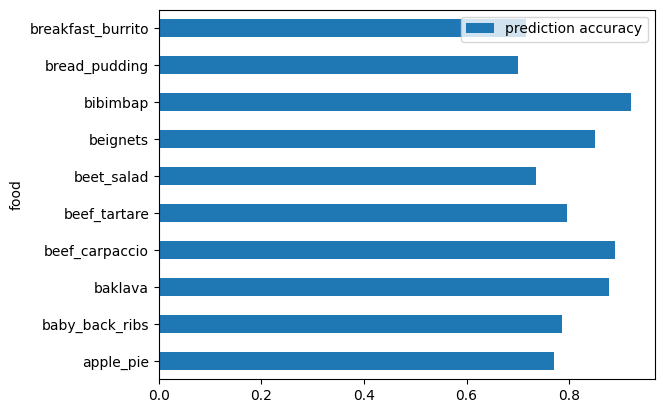

In [39]:
df[:10].plot.barh("food","prediction accuracy")

Как можно заметить нейросеть достаточно хорошо распознает все блюда